# Setup

In [1]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import h5py
import copy
import random
import pandas as pd
import keras_tuner as kt
import pandas as pd

from scipy import stats
from numba import cuda
from sklearn.model_selection import train_test_split as _train_test_split


import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow_probability import distributions
from tensorflow_probability import math
from tensorflow_probability import distributions
from tensorflow_probability import math as tfpmath

# workaround to import pdn and CLR from another forlder while they are not installed
import sys
sys.path.insert(0,'../ML_tracer_painting/')
sys.path.insert(0,'./')

#import pdn
import clr_callback as CLR

tf.config.optimizer.set_jit(True)  #setting the XLA (Accelerated Linear Algebra) flag 

# # Check if a GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# # Ensure TensorFlow is configured to use the GPU
assert tf.test.is_gpu_available(), "No GPU detected or TensorFlow is not configured to use it."


2024-02-02 09:26:57.840909: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-02 09:26:57.881811: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-02 09:26:57.881838: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-02 09:26:57.881844: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-02 09:26:57.888194: I tensorflow/core/platform/cpu_feature_g

Num GPUs Available:  1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2024-02-02 09:27:00.465359: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-02 09:27:00.501100: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-02 09:27:00.501363: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
%matplotlib inline

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif"
})

In [3]:
directory_path = "/home/ubuntu/Thesis/quijote/" # add path to the data directory

## Loading the Data
We are considering $k_{max} = 0.2$ "mildly linear" case. The data "df" contains the normalized parameters and summary statistics in one single data frame. The data "df_lbl" contains the normalised parameters. The summary statistics used here are power spectrum (P0_0 - P0_31),
marked power spectrum(MP0, MP01, MP02, MP04 each with 32 entries eg. MP0_0 - MP0_31), bispectrum(B_0 - B_72),marked bispectrum(MB, MB1, MB2, MB4 each with 67 entries from MB_0 -MB_66) and halo mass function(HMF_0-HMF_11). The labels contains the parameters $f_{NL}^{eq}$,$\Omega_m$,$h$,$n_s$,$\sigma_8$

In [4]:
## Reading the Data
df_all = pd.read_csv(directory_path + "data_lh_0pt5.csv")

## Unnormalised parameters
df_lbl = pd.read_csv(directory_path + "unnormalised_lbl.csv")
mean_params = df_lbl.mean(axis=0).values # mean of params
std_params = df_lbl.std(axis = 0).values # standard deviation of params
cov_params = df_lbl.cov().values





In [5]:
df_all

,fnl_equil,Om,h,ns,s8,P0_0,P0_1,P0_2,P0_3,P0_4,...,HMF_2,HMF_3,HMF_4,HMF_5,HMF_6,HMF_7,HMF_8,HMF_9,HMF_10,HMF_11
0,0.579947,0.285646,-0.895023,0.628420,-0.770378,7.694324e+04,72699.988971,80060.577932,66006.190973,60844.371143,...,16901,9873,5786,3040,1506,618,221,67,11,3
1,-0.219861,-0.161000,-0.822313,-1.296658,1.237798,1.784552e+05,217724.754529,170829.183345,122275.653483,111882.779876,...,15712,10474,6948,4290,2654,1600,882,450,163,71
2,-1.185862,-1.317432,-0.901948,0.725367,-1.570185,1.272849e+06,877065.512870,691072.249241,417614.884669,360848.651773,...,2035,1041,499,215,70,23,9,0,0,0
3,-0.545323,0.302957,1.327819,-1.687906,1.248185,4.066970e+04,72895.619417,78330.482070,70627.845993,64061.072840,...,22477,14804,9930,6219,3777,2095,1088,509,209,58
4,1.660207,1.680981,-1.109690,1.680981,0.077903,1.245194e+04,18920.361863,22937.191376,27123.116865,24749.233084,...,39873,26164,16630,9836,5274,2730,1176,408,133,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-1.632508,-1.435153,0.818851,0.929647,0.870786,6.906393e+05,477106.546386,407935.986024,252411.271003,168527.313031,...,6247,3820,2194,1260,671,306,139,48,15,4
996,-1.590959,0.320269,-1.667132,0.199086,-1.428228,9.062285e+04,118855.924989,115250.670403,107756.660844,90393.284458,...,11838,6488,3456,1692,786,248,81,14,5,0
997,0.694205,0.940034,-0.264871,0.271796,-0.323732,2.706000e+04,35874.495733,42646.730659,42935.895217,38941.706934,...,26815,16834,10118,5692,3005,1414,569,191,50,12
998,0.507237,-0.635345,-1.206636,0.424140,-1.403991,3.310482e+05,330489.896973,242223.693255,216801.822755,162986.136645,...,6081,3249,1739,788,353,136,43,8,2,0


#### Creating different datasets for different summary statistics.

In [6]:
# PARMAETERS AND SUMMARY STATISTICS 
"""
sliced the main dataset into different statistics
"""
norm_lbl = df_all.loc[:,'fnl_equil':'s8']
P0  = df_all.loc[:,'P0_0':'P0_79']
MP0 = df_all.loc[:,'MP01_0':'MP04_79']
B0  = df_all.loc[:,'B_0':'B_72']
MB  = df_all.loc[:,'MB1_0':'MB4_66']
HMF = df_all.loc[:,'HMF_0':'HMF_11']
MP0_0 = df_all.loc[:,'MP0_0':'MP0_79']
MB0  = df_all.loc[:,'MB_0':'MB_66']


In [7]:
# Function to create input data fot combination of summary statistics

def input_data(columns,norm_lbl):
    
    """
    columns: it takes a list input of the summary statistics
    norm_lb: it is the normalised label of the parameters
    selects the different summary statistics 
    to make it into a single dataframe, which 
    can then be used as the input in the NN.
    """
    
    assert isinstance(columns, list), "Input is not a list"
    df_columns = pd.concat(columns,axis =1)
    
    return pd.concat([norm_lbl,df_columns],axis=1)


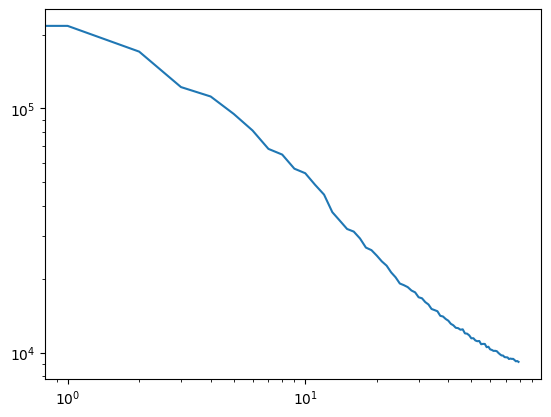

In [8]:
#Plotting the power spectrum
plt.plot(P0.T[1])             # Transposing to plot power spectrum for each simulation 
plt.loglog()
plt.show()


#### Data splitting into Train, Validation and Test set

In [9]:
def train_val_test_split(df,params = 5,random_state =1, train_frac = 0.6,test_frac = 0.2):
    
    """
    df: The input dataframe
    params: the number of params default set to 5. Change if adding more parameters
    train_frac: fraction of training data
    test_frac: fraction of test data
    """
    
    # Permuting the DataFrame to avoid any bias.
    
    df = df.sample(frac=1,random_state=random_state) 

    #seperating the input and labels in the df

    X = df[df.columns[params:]]
    y = df[df.columns[:params]]
    


    # Splitting into training, test and validation

    train_frac = train_frac
    test_frac =  test_frac
    val_frac = 1- (train_frac+test_frac)
    
#     assert train_frac + val_frac + test_frac == 1,"Fraction should add up to 1" # to ensure that the sum is one

    # defining the size for training, test and validation
    
    train_size, test_size, val_size = map(lambda frac: round(len(df) * frac), [train_frac, test_frac, val_frac])

    X_train, X_val, X_test, y_train, y_val, y_test = X[:train_size],X[train_size:train_size+test_size],X[train_size+test_size:],\
                                                     y[:train_size],y[train_size:train_size+test_size],y[train_size+test_size:]
    
    return(X_train, X_val, X_test, y_train, y_val, y_test)

# Define couple of useful functions

#### Defining the loss plot function

In [10]:
# Function defining loss plot.

def plot_loss(df_history, ylim=None, logy=False):
    plt.figure(figsize=(12,8 ))
    
    plt.plot(df_history.index, df_history['loss'], label='Training_loss')
    plt.plot(df_history.index, df_history['val_loss'], label='Validation_loss')


    if logy:
        plt.semilogy()
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
#     print(key)
    plt.title("Training and Validation Loss")
    plt.grid(True)
    plt.show()

#### LaTex Label Names

In [11]:
label_LaTeX_names_vanilla = [
    r"$\Omega_m$",
    r"$\Omega_b$",
    r"$h$",
    r"$n_s$",
    r"$\sigma_8$"
]

label_LaTeX_names_equilateral = [r"$f_{NL}^{eq}$", 
                                 r"$\Omega_m$",
                                 r"$h$",
                                 r"$n_s$",
                                 r"$\sigma_8$"]

#### Defining Elu+1 activation function
Used for positive definiteness of the Sigma outputs. ELU gives a negative output however for the sigma values we need a positive definiteness so ELU+1 helps with that

In [12]:
def elu_plus_one(input):

    """ Adds one to the Exponential Linear Unit

    """

    return tf.add(

       tf.nn.elu(input),

        tf.constant(1.0000001, dtype=tf.float32) # Notice I added 1.e-7 for stability

    )

tf.keras.utils.get_custom_objects().update({'elu_plus_one': layers.Activation(elu_plus_one)})

##############################################################################################################################

# Analysis

#############################################################################################################################

## Building the model
Creating layers and defining hyperparameter tuninig.

In [13]:
def hp_model_for_dataset():
    class MyHyperModel(kt.HyperModel):
        def build(self, hp):
            #############################   Hyper-tuning Parameters  #############################
            num_layers = hp.Int('num_layers', min_value=1, max_value= 8) #3
            architecture = [hp.Int(f"unit_num_{i}", min_value=32, max_value=1024, step=32) for i in range(num_layers)]  #[384, 96, 256]
            dropout_rate =  hp.Float('dropout_rate',min_value= 0.1, max_value= 0.5, sampling="log") #0.10320930206682662
            opt_learning_rate = hp.Float('learning_rate',min_value= 1e-5, max_value= 1e-2, sampling="log") #optimizer learning rate 0.00030932800521408247 #
            regularization_rate = hp.Float('l2_regularization', min_value=1e-5, max_value=1e-2, sampling="log")


            #############################   Creating Layers  #############################
       

            inputs = Input(shape=X_training_set.shape[1], name="input_layer")
            normalize_layer = layers.Normalization()
            normalize_layer.adapt(X_training_set)
            norm_inputs = normalize_layer(inputs)
            input_layer = norm_inputs
            # Adding hidden dense layers which is specified by the architecture
            for i, n_nodes in enumerate(architecture[:-1]):
                input_layer = layers.Dense(
                    n_nodes,
                    activation="selu",
                    kernel_initializer="he_normal",
                    name=f"dense_layer_{i + 1}"
                )(input_layer)
                input_layer = layers.Dropout(dropout_rate, name=f"dropout_{i + 1}")(input_layer)

            # Adding the last hidden layer without dropout
            input_layer = layers.Dense(
                architecture[-1],
                activation="selu",
                kernel_initializer="he_normal",
                name=f"dense_layer_{len(architecture)}"
            )(input_layer)

            ######################################### Defining Ouputs #################################################################         
           
            target_variable_number = y_training_set.shape[-1]
            
            def initializer_pseudo_sigmas(shape, dtype=None):
                
                return ((0.5*tf.ones(shape)+tf.random.uniform(shape))/ np.sqrt(shape[0])/10.
                        * tf.cast(tfpmath.fill_triangular_inverse(np.identity(target_variable_number)), dtype=dtype) )
                
#           ##############################################################################################################
            
          
            
            
            means = layers.Dense(target_variable_number,
                                 activation="linear",
                                 kernel_initializer="he_normal")(input_layer) #(last_hidden_layer)
            
            
            # tf.print("Reg_rate", regularization_rate)
            pseudo_sigmas = layers.Dense(target_variable_number*(target_variable_number+1)/2,
                                         activation="linear",
                                          kernel_initializer=initializer_pseudo_sigmas,
                                         kernel_regularizer=regularizers.l2(regularization_rate)
                                        )(input_layer) #(last_hidden_layer)initializer_pseudo_sigmas
            
            output_layer = layers.Concatenate()([means, pseudo_sigmas])
                        

            #############################   Creating Model  #############################
            
            model = Model(inputs=inputs, outputs=output_layer)
            
            # tf.print("opt_learning_rate:", opt_learning_rate)
            model.compile(
                loss=mse_means_and_sigmas_uncorrelated,
                optimizer=tf.optimizers.Adam(learning_rate= opt_learning_rate),
            )
            # model.summary()

            return model

        
        def fit(self, hp, model, *args, callbacks=[], **kwargs):
           
            #############################   Hyper-tuning CLR and batch size #############################
           
            
           
            hp_base_learning_rate =  hp.Float('base_learning_rate', min_value=1e-5, max_value=1e-2, sampling="log")#9.365959093508116e-05
            # tf.print("Cyclic lR:",hp_base_learning_rate)
            
            #Add cyclic lr
            clr_triangular = CLR.CyclicLR(
                base_lr=hp_base_learning_rate,
                max_lr=hp_base_learning_rate * 4.,
                step_size=3 * 4,  # recommended (2-8) x (training iterations in epoch)
                gamma=0.99994)
            
            # Add ModelCheckpoint to save the best weights
            checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                'best_weights.h5',
                monitor='val_loss',
                save_best_only=True,
                save_weights_only=True,
                mode='min',
                verbose= 0
            )

            batch_size = hp.Choice("batch_size", [16, 32, 64, 128, 256, 512])
            # tf.print("batch size:",batch_size)
            return model.fit(
                *args,
                callbacks=callbacks + [clr_triangular],#,checkpoint_callback],#,checkpoint_callback],
                batch_size=batch_size,
                **kwargs
            )

    return MyHyperModel()

## Defining loss

In [14]:
def mse_means_and_sigmas_uncorrelated(y_true, y_pred):
    
  
    num_of_parameters=tf.cast((tf.math.sqrt(tf.cast(8*y_pred.shape[-1]+9, dtype=tf.float16))-3)/2, dtype=tf.int32)


    means_pred,pseudo_sigmas_pred = tf.split(y_pred,# L_dig_pred,L_offdig_pred

                                              num_or_size_splits=[

                                                  num_of_parameters,
                                                  # num_of_parameters,

                                                  tf.cast(num_of_parameters*(num_of_parameters+1)/2, dtype=tf.int32)

                                              ], axis=-1)
    L = tfpmath.fill_triangular(pseudo_sigmas_pred)
   
    dist = distributions.MultivariateNormalTriL(

        loc=means_pred,

        scale_tril=L,

    )
    

    loglkl = dist.log_prob(y_true)

    return -tf.math.reduce_mean(loglkl)
    
    
    
    

## Define callbacks

In [15]:
def callback_early_stopping(monitor='val_loss', patience=100): #, max_delta=50):
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor=monitor,
        # min_delta=50,
        patience=patience,
        restore_best_weights=True,
        verbose=0,
        mode='min'
    )

    return [early_stopping]#,lossHistory]#,custom_early_stopping]

## Define some ancillary stuff

In [84]:
def check_predictions(trueY, predicY, predicE, label='quantity [some units]', numbins=100, title=None):
    fig, ax = plt.subplots(ncols=3,sharex=True,figsize=(9,2.8))#6.4,2.8 #6.4,4.8

    ax[0].errorbar(
        x=trueY[:], y=predicY,
        yerr=predicE,
        elinewidth=0.5,
        linewidth=0,
        #bins='log', xscale='log', yscale='log',
        #gridsize=numbins
    )
    extremes = [np.min([trueY, predicY]),np.max([trueY, predicY])]    
    ax[0].set_xlabel('True '+label)
    ax[0].set_ylabel('Predicted '+label)
    ax[0].plot(extremes, extremes, c='k')
    ax[0].set_xlim(extremes[0], extremes[1])
    ax[0].set_ylim(extremes[0], extremes[1])
    ax[0].set_aspect('equal', adjustable='box')
    
    ymean = np.mean(trueY)
    R2 = 1.-np.sum((trueY-predicY)**2) / np.sum((trueY-ymean)**2)
    
    ax[0].text(0.975, 0.025, r'$R^2$=%.2f'
               "\n"
               r"$\chi^2$=%.2f" %(R2, np.sum((trueY - predicY)**2/predicE**2)/(len(predicE)-2)),
               style='italic', transform=ax[0].transAxes,
        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 2}, ha="right", va="bottom")
    
    ax[1].plot(trueY, predicE, marker=".", lw=0, markersize=2, alpha=1)
    ax[1].set_xlabel('True '+label)
    ax[1].set_ylabel('Standard deviation')
    ax[1].text(0.975, 0.025, r'$\langle\sigma \rangle$=%.2f'
               "\n"
               r"RMSE=%.2f" %(np.mean(predicE), np.sqrt(np.mean((predicY-trueY)**2))), 
               style='italic', transform=ax[1].transAxes,
               bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 2},
               ha="right", va="bottom")
    
    ax[2].grid(axis="y",alpha=0.5,ls="--")
    
    ax[2].plot(trueY, (predicY-trueY)/predicE, marker=".", lw=0, markersize=2, alpha=1)
    ax[2].set_xlabel('True '+label)
    ax[2].set_ylabel(r'Bias [$\sigma$]')
    ax[2].grid(axis="y",alpha=0.5,ls="--")
    ax[2].text(0.975, 0.025, r"$\langle bias \rangle$=%.2f"
               "\n"
               r"$\langle |bias| \rangle$=%.2f" % (np.mean((predicY-trueY)/predicE), np.mean(np.abs(predicY-trueY)/predicE)), 
               style='italic', transform=ax[2].transAxes,
               bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 2},
               ha="right", va="bottom")
    plt.tight_layout()
    
    if title is not None:
        plt.subplots_adjust(left=0.1, right=0.975, top=0.9, bottom=0.2)
        plt.suptitle(title)#, fontdict={'horizontalalignment': "center"})
    else:
        plt.subplots_adjust(left=0.05, right=0.975, top=0.975, bottom=0.2)
    fig.show()
    

In [85]:
# prediction of parameters
def prediction(model,X_test_set,y_test_set,mean_params,std_params,title):
    
  
    
    assert isinstance(title, str), "Title must be a string"
    
    predictions = model.predict(X_test_set, verbose=0)
    
    df_predictions = pd.DataFrame(predictions) 
    y_mean_predict = df_predictions[df_predictions.columns[:5]]
    y_cov_predict = df_predictions[df_predictions.columns[5:]]
    
    """
    takes the lower triangular part of the covariance predictions,
    fills it to reconstruct the full covariance matrix, 
    and then extracts the standard deviations from the diagonal elements of the covariance matrix. 
    """
    
    L = tfpmath.fill_triangular(y_cov_predict)
    cov_matrix = tf.matmul(L,L, transpose_b=True)
    y_sigma_predict = tf.sqrt(tf.linalg.diag_part(cov_matrix))
    
    # y_sigma_predict = df_predictions[df_predictions.columns[5:]]
    
    true_y = ((y_test_set * std_params) + mean_params).reset_index(drop=True).values
    predict_y = ((y_mean_predict * std_params)  + mean_params).values
    predict_E = (y_sigma_predict*std_params).numpy()
    # print("Returns true_y, predict_y, predict_E, df_predictions")
    
   
    
    #Plot of Predicted, std_dev, Bias vs True 
    for j in range(len(mean_params)):
        check_predictions(
            true_y[:,j],
            predict_y[:,j],
            predict_E[:,j],
            label=label_LaTeX_names_equilateral[j],
            title= title)
    return (true_y,predict_y,predict_E,df_predictions,y_cov_predict)
    


# Tuning hyperparameters

In [18]:
columns0 = [P0,B0]#checkdoing only 20
columns1 = [P0,MP0_0]#doing
columns2 = [P0,B0,MP0_0,MB0]#check only 20
columns3 = [P0,B0,HMF]
columns4 = [P0,MP0_0,HMF]#done
columns5 = [P0,B0,MP0_0,MB0,HMF]#done

# 0. P0,B0


In [19]:
columns = columns0 #P0,B0
df_0 = input_data(columns,norm_lbl)

In [20]:
df_0

,fnl_equil,Om,h,ns,s8,P0_0,P0_1,P0_2,P0_3,P0_4,...,B_63,B_64,B_65,B_66,B_67,B_68,B_69,B_70,B_71,B_72
0,0.579947,0.285646,-0.895023,0.628420,-0.770378,7.694324e+04,72699.988971,80060.577932,66006.190973,60844.371143,...,7.643267e-07,-1.568370e-05,0.000031,-1.990206e-05,1.086079e-06,-8.771411e-07,1.380725e-05,5.697872e-06,-6.634727e-06,2.148546e-05
1,-0.219861,-0.161000,-0.822313,-1.296658,1.237798,1.784552e+05,217724.754529,170829.183345,122275.653483,111882.779876,...,3.451879e-05,4.681457e-05,0.000074,-3.218503e-05,-3.811616e-06,2.405458e-06,8.667817e-05,1.011580e-05,-1.396160e-05,7.812197e-05
2,-1.185862,-1.317432,-0.901948,0.725367,-1.570185,1.272849e+06,877065.512870,691072.249241,417614.884669,360848.651773,...,8.926800e-04,2.401686e-03,0.001341,-8.664985e-04,-1.069659e-03,-3.941795e-05,3.377362e-03,3.210027e-04,-1.196939e-03,3.555998e-03
3,-0.545323,0.302957,1.327819,-1.687906,1.248185,4.066970e+04,72895.619417,78330.482070,70627.845993,64061.072840,...,5.031478e-07,-1.300059e-05,0.000023,-1.218684e-05,1.200759e-06,-2.743941e-07,-2.794380e-06,1.100405e-07,5.001262e-07,2.203571e-06
4,1.660207,1.680981,-1.109690,1.680981,0.077903,1.245194e+04,18920.361863,22937.191376,27123.116865,24749.233084,...,-4.424328e-06,-2.952979e-06,0.000005,-8.894823e-07,1.281311e-06,5.820166e-07,1.679504e-06,3.088323e-07,-4.834062e-07,-3.731113e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-1.632508,-1.435153,0.818851,0.929647,0.870786,6.906393e+05,477106.546386,407935.986024,252411.271003,168527.313031,...,1.724055e-04,4.550981e-04,0.000308,-1.821930e-04,-1.634060e-04,-2.029786e-05,6.379504e-04,6.544970e-05,-1.833681e-04,5.512911e-04
996,-1.590959,0.320269,-1.667132,0.199086,-1.428228,9.062285e+04,118855.924989,115250.670403,107756.660844,90393.284458,...,1.471389e-05,-1.361908e-05,0.000060,-3.964805e-05,1.035488e-06,2.686301e-06,2.798894e-05,6.202776e-06,-1.308891e-05,-7.826151e-07
997,0.694205,0.940034,-0.264871,0.271796,-0.323732,2.706000e+04,35874.495733,42646.730659,42935.895217,38941.706934,...,-7.643679e-06,-1.233308e-05,0.000009,-6.558545e-06,2.504809e-06,4.852878e-07,-3.045335e-07,-1.524427e-07,-7.265532e-07,3.226926e-06
998,0.507237,-0.635345,-1.206636,0.424140,-1.403991,3.310482e+05,330489.896973,242223.693255,216801.822755,162986.136645,...,1.187972e-04,1.739441e-04,0.000230,-1.453472e-04,-8.753987e-05,-9.839072e-06,3.341113e-04,2.977944e-05,-8.742129e-05,2.266966e-04


In [21]:
X0_train, X0_val, X0_test, y0_train, y0_val, y0_test = train_val_test_split(df_0 ,random_state = 1)

In [22]:
X_training_set = X0_train
y_training_set = y0_train

tuner0 = kt.BayesianOptimization(
    hp_model_for_dataset(),
    objective= 'val_loss',
    max_trials = 100,
    directory='/mnt/keras_tuner_dir-new/',
    project_name ='P0_B0__l2reg-patience100__0_100trials', #trained with kernel regularizer for pseudo_sigma
    )


# Running the HyperParameter Search

tuner0.search(X0_train, y0_train, validation_data=(X0_val, y0_val), epochs=1000000, callbacks= callback_early_stopping())#100000



Trial 100 Complete [00h 00m 16s]
val_loss: 15.539401054382324

Best val_loss So Far: 1.0276952981948853
Total elapsed time: 00h 42m 01s


In [23]:
best_hp0 = tuner0.get_best_hyperparameters(num_trials=1)[0]
best_num_layers = best_hp0.get('num_layers')
best_architecture = [best_hp0.get(f"unit_num_{i}") for i in range(best_num_layers)]
best_learning_rate = best_hp0.get('learning_rate')
best_base_learning_rate = best_hp0.get('base_learning_rate')
best_dropout_rate = best_hp0.get('dropout_rate')
best_regularization_rate =best_hp0.get('l2_regularization')
best_batch_size = best_hp0.get('batch_size')
print(f"""
Best Hyperparameters:
- Number of Layers: {best_num_layers}
- Architecture: {best_architecture}
- Opt_Learning Rate: {best_learning_rate}
- Base Learning Rate (CLR): {best_base_learning_rate}
- Dropout Rate: {best_dropout_rate}
- Regularization Rate:{best_regularization_rate}
- Batch Size: {best_batch_size}
""")
# -Regularization Rate:{best_regularization_rate}

# - Number of Layers: {best_num_layers}
# - Architecture: {best_architecture}
# -Base Learning Rate (CLR): {best_base_learning_rate}
# - Opt_Learning Rate: {best_learning_rate}
#- Dropout Rate: {best_dropout_rate}



Best Hyperparameters:
- Number of Layers: 5
- Architecture: [800, 960, 928, 480, 352]
- Opt_Learning Rate: 8.35107687210878e-05
- Base Learning Rate (CLR): 2.8215091657002673e-05
- Dropout Rate: 0.12494776547524414
- Regularization Rate:1.2525947662748231e-05
- Batch Size: 64



In [24]:
# TUNER SUMMARY
print(tuner0.results_summary())
best_model0 = tuner0.get_best_models()[0]
best_model0.summary()

Results summary
Results in /mnt/keras_tuner_dir-new/P0_B0__l2reg-patience100__0_100trials
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 002 summary
Hyperparameters:
num_layers: 5
unit_num_0: 800
dropout_rate: 0.12494776547524414
learning_rate: 8.35107687210878e-05
l2_regularization: 1.2525947662748231e-05
unit_num_1: 960
unit_num_2: 928
unit_num_3: 480
unit_num_4: 352
unit_num_5: 128
unit_num_6: 576
unit_num_7: 704
base_learning_rate: 2.8215091657002673e-05
batch_size: 64
Score: 1.0276952981948853

Trial 056 summary
Hyperparameters:
num_layers: 8
unit_num_0: 960
dropout_rate: 0.27214087272523685
learning_rate: 0.00028468692606757715
l2_regularization: 0.002530626244508597
unit_num_1: 576
unit_num_2: 192
unit_num_3: 192
unit_num_4: 320
unit_num_5: 512
unit_num_6: 640
unit_num_7: 96
base_learning_rate: 0.00011544968446583018
batch_size: 256
Score: 1.753676414489746

Trial 012 summary
Hyperparameters:
num_layers: 7
unit_num_0: 384
dropout_rate: 0.11266503408597

In [25]:
# Fitting the model
hypermodel0 = hp_model_for_dataset()
best_model0 = hypermodel0.build(best_hp0)
histories0= hypermodel0.fit(best_hp0,best_model0,
    X0_train,
    y0_train,
    validation_data=(X0_val,
                     y0_val),
    epochs=1000000,
    callbacks= callback_early_stopping(),
    verbose=1,
)
# Histories return 
df0_history = pd.DataFrame(histories0.history)

Epoch 1/1000000
10/10 [==============================] - 3s 78ms/step - loss: 465381.4375 - val_loss: 400.8005
Epoch 2/1000000
10/10 [==============================] - 1s 79ms/step - loss: 31.3721 - val_loss: 19.1070
Epoch 3/1000000
10/10 [==============================] - 0s 8ms/step - loss: 269.7509 - val_loss: 18.1046
Epoch 4/1000000
10/10 [==============================] - 0s 8ms/step - loss: 21.7138 - val_loss: 17.6629
Epoch 5/1000000
10/10 [==============================] - 0s 8ms/step - loss: 21.1371 - val_loss: 17.5677
Epoch 6/1000000
10/10 [==============================] - 0s 8ms/step - loss: 21.5195 - val_loss: 17.5164
Epoch 7/1000000
10/10 [==============================] - 0s 8ms/step - loss: 21.3559 - val_loss: 17.4805
Epoch 8/1000000
10/10 [==============================] - 0s 8ms/step - loss: 21.1204 - val_loss: 17.4649
Epoch 9/1000000
10/10 [==============================] - 0s 8ms/step - loss: 21.9836 - val_loss: 17.4373
Epoch 10/1000000
10/10 [=======================

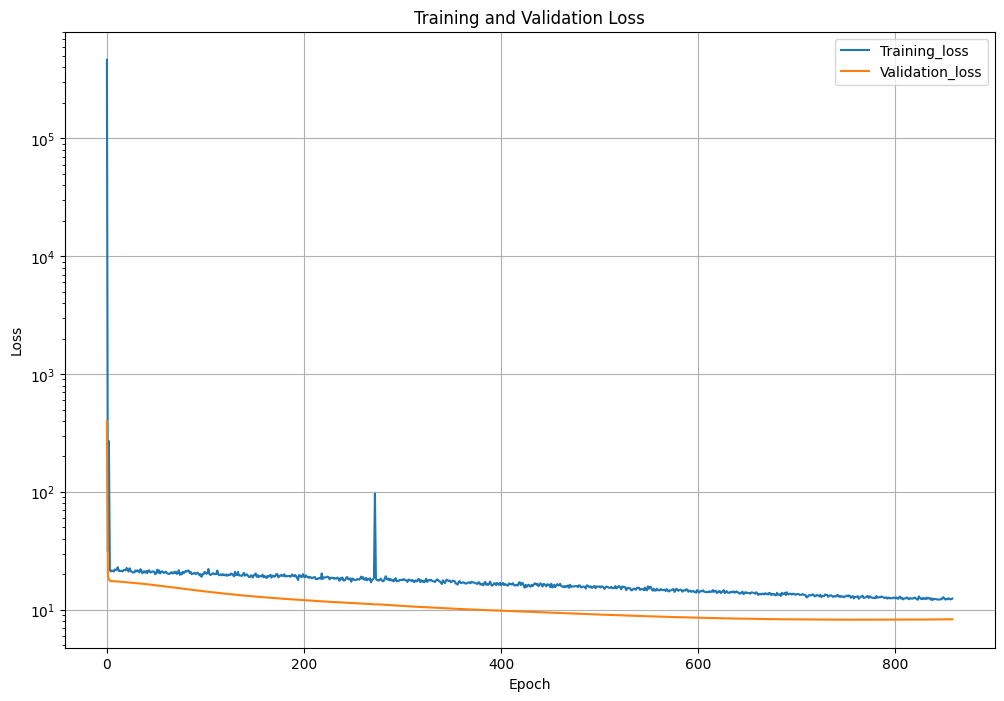

,loss,val_loss
0,465381.437500,400.800507
1,31.372076,19.106989
2,269.750885,18.104565
3,21.713785,17.662865
4,21.137150,17.567659
...,...,...
854,12.509545,8.297155
855,12.427906,8.300465
856,12.237263,8.302284
857,12.309925,8.304724


In [66]:
plot_loss(df0_history,logy=True)#, ylim=[0, 25])
df0_history

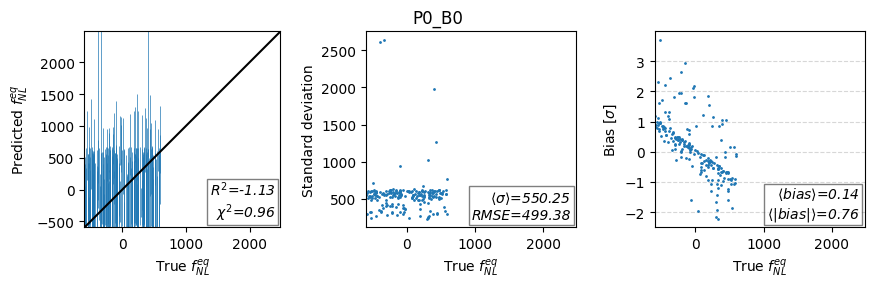

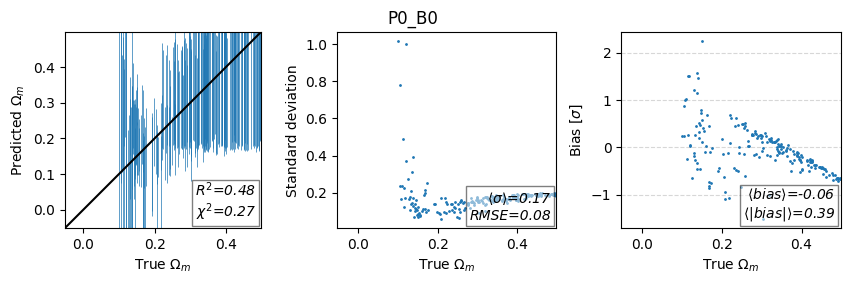

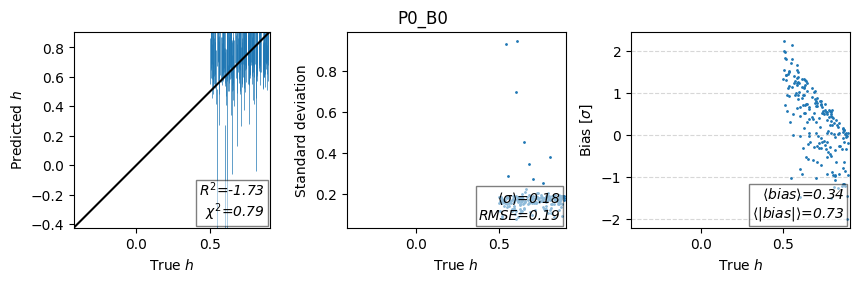

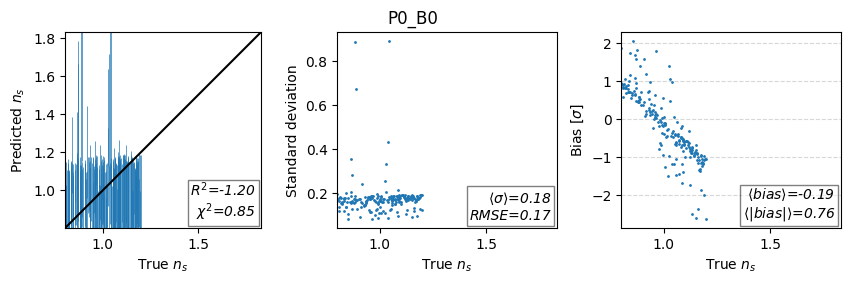

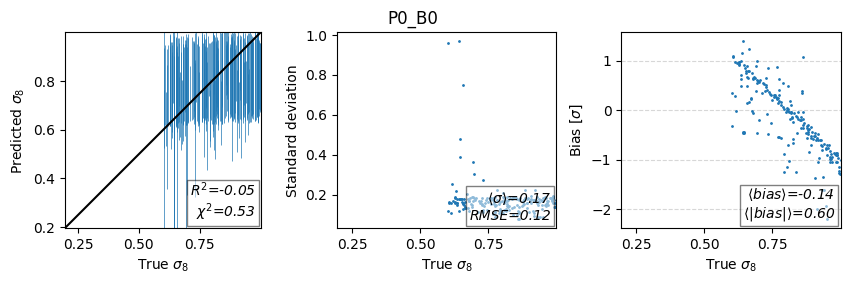

In [86]:
predictions0 = prediction(best_model0,X0_test,y0_test,mean_params,std_params,title = "P0_B0")


# 1. P0,MP0_0

In [28]:
columns = columns1 #P0,MP0_0

df_1 = input_data(columns,norm_lbl)
X1_train, X1_val, X1_test, y1_train, y1_val, y1_test = train_val_test_split(df_1 ,random_state = 1)

In [29]:
X_training_set = X1_train
y_training_set = y1_train

tuner1 = kt.BayesianOptimization(
    hp_model_for_dataset(),
    objective= 'val_loss',
    max_trials = 100,
    directory='/mnt/keras_tuner_dir-new/',
    project_name ='P0_MP0_0__l2reg-patience100__0_100trials', #trained with kernel regularizer for pseudo_sigma
    )
# Running the HyperParameter Search
tuner1.search(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=1000000, callbacks= callback_early_stopping())#100000

Trial 100 Complete [00h 01m 27s]
val_loss: 40.164695739746094

Best val_loss So Far: 1.2394682168960571
Total elapsed time: 00h 52m 58s


In [30]:
best_hp1 = tuner1.get_best_hyperparameters(num_trials=1)[0]
best_num_layers = best_hp1.get('num_layers')
best_architecture = [best_hp1.get(f"unit_num_{i}") for i in range(best_num_layers)]
best_learning_rate = best_hp1.get('learning_rate')
best_dropout_rate = best_hp1.get('dropout_rate')
best_base_learning_rate = best_hp1.get('learning_rate')
best_batch_size = best_hp1.get('batch_size')
best_regularization_rate =best_hp1.get('l2_regularization')
print(f"""
Best Hyperparameters:
- Number of Layers: {best_num_layers}
- Architecture: {best_architecture}
- Opt_Learning Rate: {best_learning_rate}
- Base Learning Rate (CLR): {best_base_learning_rate}
- Dropout Rate: {best_dropout_rate}
- Batch Size: {best_batch_size}
- Regularization Rate:{best_regularization_rate}
""")


Best Hyperparameters:
- Number of Layers: 8
- Architecture: [1024, 1024, 768, 1024, 32, 1024, 1024, 1024]
- Opt_Learning Rate: 1e-05
- Base Learning Rate (CLR): 1e-05
- Dropout Rate: 0.1
- Batch Size: 512
- Regularization Rate:0.01



In [31]:
# TUNER SUMMARY
print(tuner1.results_summary())
best_model1 = tuner1.get_best_models()[0]
best_model1.summary()

Results summary
Results in /mnt/keras_tuner_dir-new/P0_MP0_0__l2reg-patience100__0_100trials
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 082 summary
Hyperparameters:
num_layers: 8
unit_num_0: 1024
dropout_rate: 0.1
learning_rate: 1e-05
l2_regularization: 0.01
unit_num_1: 1024
unit_num_2: 768
unit_num_3: 1024
unit_num_4: 32
base_learning_rate: 1e-05
batch_size: 512
unit_num_5: 1024
unit_num_6: 1024
unit_num_7: 1024
Score: 1.2394682168960571

Trial 065 summary
Hyperparameters:
num_layers: 8
unit_num_0: 96
dropout_rate: 0.1
learning_rate: 3.2321417573624866e-05
l2_regularization: 0.01
unit_num_1: 1024
unit_num_2: 1024
unit_num_3: 1024
unit_num_4: 1024
base_learning_rate: 1e-05
batch_size: 64
unit_num_5: 1024
unit_num_6: 1024
unit_num_7: 160
Score: 1.4882205724716187

Trial 068 summary
Hyperparameters:
num_layers: 8
unit_num_0: 800
dropout_rate: 0.1
learning_rate: 0.01
l2_regularization: 0.01
unit_num_1: 1024
unit_num_2: 32
unit_num_3: 1024
unit_num_4: 1024
ba

In [32]:
# Fitting the model
hypermodel1 = hp_model_for_dataset()
best_model1 = hypermodel1.build(best_hp1)
histories1= hypermodel1.fit(best_hp1,best_model1,
    X1_train,
    y1_train,
    validation_data=(X1_val,
                     y1_val),
    epochs=1000000,
    callbacks= callback_early_stopping(),
    verbose=1,
)
# Histories return 
df1_history = pd.DataFrame(histories1.history)

Epoch 1/1000000
2/2 [==============================] - 4s 731ms/step - loss: 15.6254 - val_loss: 12.5502
Epoch 2/1000000
2/2 [==============================] - 1s 711ms/step - loss: 14.7512 - val_loss: 12.2976
Epoch 3/1000000
2/2 [==============================] - 0s 44ms/step - loss: 14.5681 - val_loss: 11.8320
Epoch 4/1000000
2/2 [==============================] - 0s 42ms/step - loss: 14.2440 - val_loss: 11.7875
Epoch 5/1000000
2/2 [==============================] - 0s 27ms/step - loss: 13.8299 - val_loss: 11.9015
Epoch 6/1000000
2/2 [==============================] - 0s 26ms/step - loss: 13.4715 - val_loss: 12.1728
Epoch 7/1000000
2/2 [==============================] - 0s 43ms/step - loss: 13.2686 - val_loss: 9.9782
Epoch 8/1000000
2/2 [==============================] - 0s 42ms/step - loss: 12.9961 - val_loss: 9.1528
Epoch 9/1000000
2/2 [==============================] - 0s 42ms/step - loss: 12.9111 - val_loss: 9.0283
Epoch 10/1000000
2/2 [==============================] - 0s 27ms/s

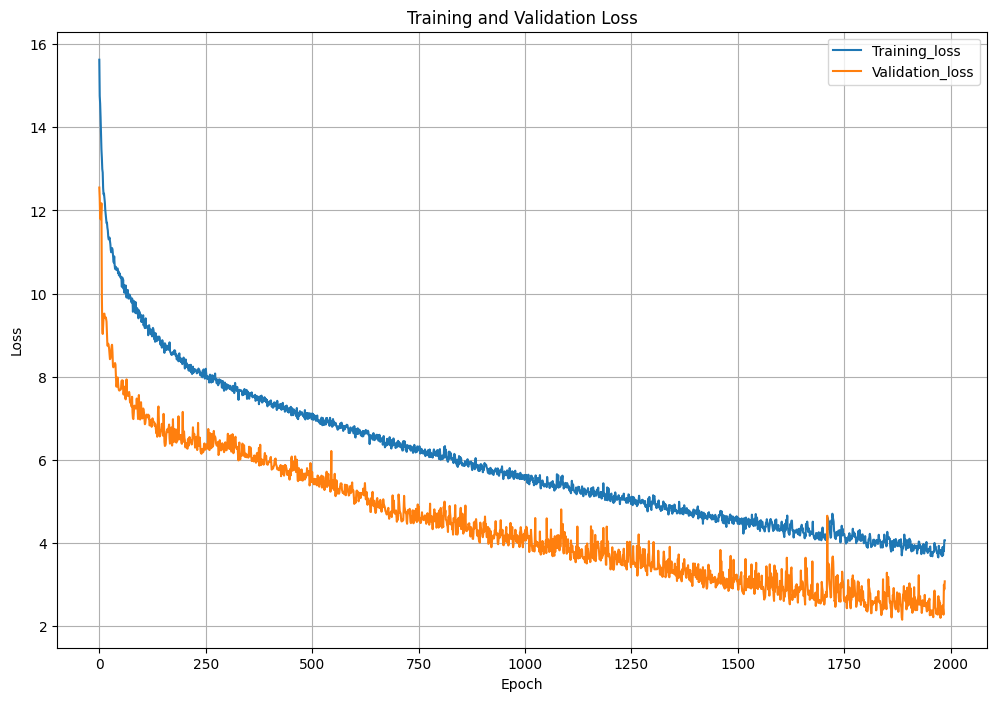

,loss,val_loss
0,15.625420,12.550227
1,14.751184,12.297583
2,14.568109,11.832035
3,14.243984,11.787506
4,13.829947,11.901499
...,...,...
1982,3.706116,2.414913
1983,3.905899,2.274734
1984,3.805067,2.995097
1985,4.067311,2.885092


In [33]:
plot_loss(df1_history)#,logy=True)#, ylim=[0, 25])
df1_history

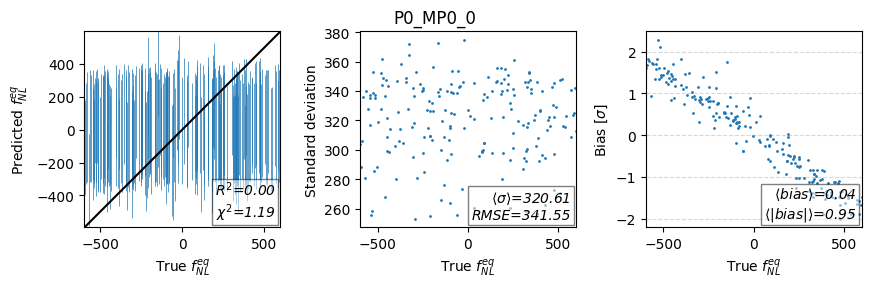

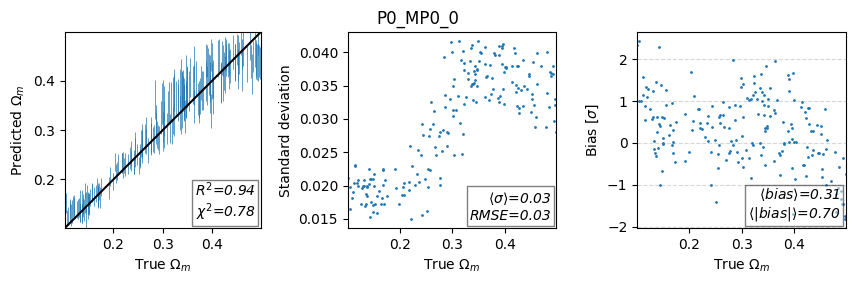

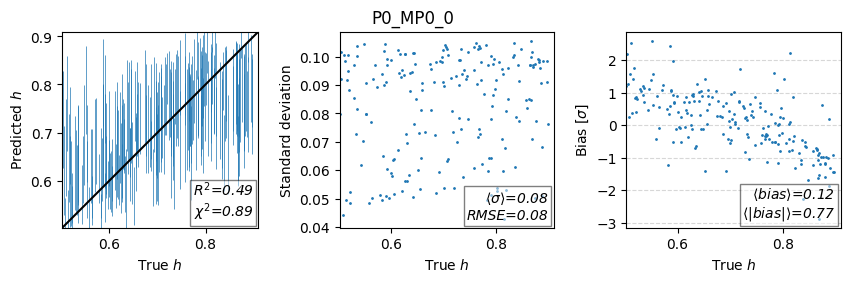

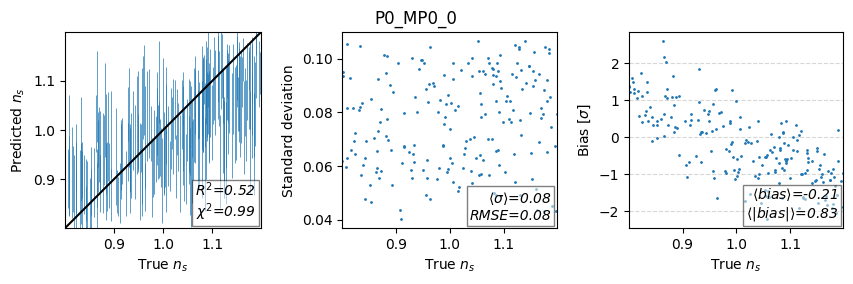

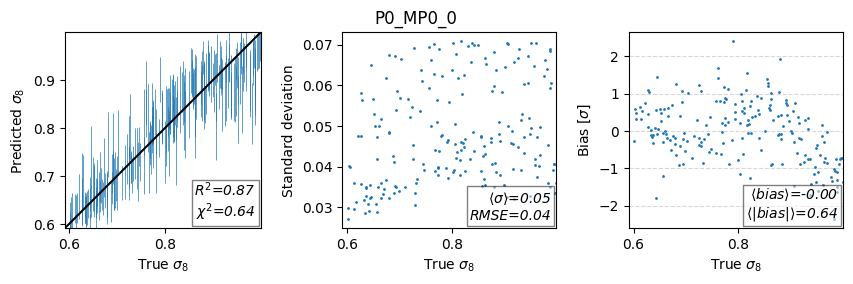

In [69]:
predictions1 = prediction(best_model1,X1_test,y1_test,mean_params,std_params,title = "P0_MP0_0")


# 2. P0,B0,MP0_0,MB0

In [35]:
columns = columns2 # P0,B0,MP0_0,MB0
df_2 = input_data(columns,norm_lbl)
X2_train, X2_val, X2_test, y2_train, y2_val, y2_test = train_val_test_split(df_2 ,random_state = 1)


In [36]:
X_training_set = X2_train
y_training_set = y2_train

tuner2 = kt.BayesianOptimization(
    hp_model_for_dataset(),
    objective= 'val_loss',
    max_trials = 100,
    directory='/mnt/keras_tuner_dir-new/',
    project_name ='P0_B0_MP0_0_MB0__l2reg-patience100__0_100trials', #trained with kernel regularizer for pseudo_sigma
    )
# Running the HyperParameter Search
tuner2.search(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=1000000, callbacks= callback_early_stopping())#100000


Trial 100 Complete [00h 00m 11s]
val_loss: 27.420347213745117

Best val_loss So Far: 1.1718602180480957
Total elapsed time: 00h 55m 13s


In [37]:

best_hp2 = tuner2.get_best_hyperparameters(num_trials=1)[0]
best_num_layers = best_hp2.get('num_layers')
best_architecture = [best_hp2.get(f"unit_num_{i}") for i in range(best_num_layers)]
best_learning_rate = best_hp2.get('learning_rate')
best_dropout_rate = best_hp2.get('dropout_rate')
best_base_learning_rate = best_hp2.get('learning_rate')
best_batch_size = best_hp2.get('batch_size')
best_regularization_rate =best_hp2.get('l2_regularization')
print(f"""
Best Hyperparameters:
- Number of Layers: {best_num_layers}
- Architecture: {best_architecture}
- Opt_Learning Rate: {best_learning_rate}
- Base Learning Rate (CLR): {best_base_learning_rate}
- Dropout Rate: {best_dropout_rate}
- Batch Size: {best_batch_size}
- Regularization Rate:{best_regularization_rate}
""")




Best Hyperparameters:
- Number of Layers: 6
- Architecture: [1024, 576, 864, 1024, 64, 640]
- Opt_Learning Rate: 0.00880179982985041
- Base Learning Rate (CLR): 0.00880179982985041
- Dropout Rate: 0.1
- Batch Size: 512
- Regularization Rate:0.0006755333953288233



In [38]:
# TUNER SUMMARY
print(tuner2.results_summary())
best_model2 = tuner2.get_best_models()[0]
best_model2.summary()



Results summary
Results in /mnt/keras_tuner_dir-new/P0_B0_MP0_0_MB0__l2reg-patience100__0_100trials
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 073 summary
Hyperparameters:
num_layers: 6
unit_num_0: 1024
dropout_rate: 0.1
learning_rate: 0.00880179982985041
l2_regularization: 0.0006755333953288233
unit_num_1: 576
unit_num_2: 864
unit_num_3: 1024
base_learning_rate: 2.342408434462891e-05
batch_size: 512
unit_num_4: 64
unit_num_5: 640
unit_num_6: 192
unit_num_7: 544
Score: 1.1718602180480957

Trial 069 summary
Hyperparameters:
num_layers: 6
unit_num_0: 1024
dropout_rate: 0.13844186161295277
learning_rate: 0.01
l2_regularization: 0.0013547171666552814
unit_num_1: 896
unit_num_2: 32
unit_num_3: 864
base_learning_rate: 1e-05
batch_size: 512
unit_num_4: 704
unit_num_5: 672
unit_num_6: 608
unit_num_7: 128
Score: 1.9580295085906982

Trial 031 summary
Hyperparameters:
num_layers: 7
unit_num_0: 1024
dropout_rate: 0.10099736379957157
learning_rate: 0.00021686067491772

In [40]:
# Fitting the model
hypermodel2 = hp_model_for_dataset()
best_model2 = hypermodel2.build(best_hp2)
histories2= hypermodel2.fit(best_hp2,best_model2,
    X2_train,
    y2_train,
    validation_data=(X2_val,
                     y2_val),
    epochs=1000000,
    callbacks= callback_early_stopping(),
    verbose=1,
)
# Histories return 
df2_history = pd.DataFrame(histories2.history)


Epoch 1/1000000
2/2 [==============================] - 4s 700ms/step - loss: 33.1345 - val_loss: 17.1501
Epoch 2/1000000
2/2 [==============================] - 1s 588ms/step - loss: 19.6661 - val_loss: 11.7582
Epoch 3/1000000
2/2 [==============================] - 0s 41ms/step - loss: 14.7234 - val_loss: 11.3931
Epoch 4/1000000
2/2 [==============================] - 0s 27ms/step - loss: 13.7362 - val_loss: 11.6536
Epoch 5/1000000
2/2 [==============================] - 0s 26ms/step - loss: 13.2730 - val_loss: 11.9454
Epoch 6/1000000
2/2 [==============================] - 0s 27ms/step - loss: 13.2389 - val_loss: 12.2660
Epoch 7/1000000
2/2 [==============================] - 0s 26ms/step - loss: 13.1571 - val_loss: 12.5609
Epoch 8/1000000
2/2 [==============================] - 0s 25ms/step - loss: 13.3684 - val_loss: 12.7265
Epoch 9/1000000
2/2 [==============================] - 0s 25ms/step - loss: 13.4807 - val_loss: 12.7797
Epoch 10/1000000
2/2 [==============================] - 0s 26m

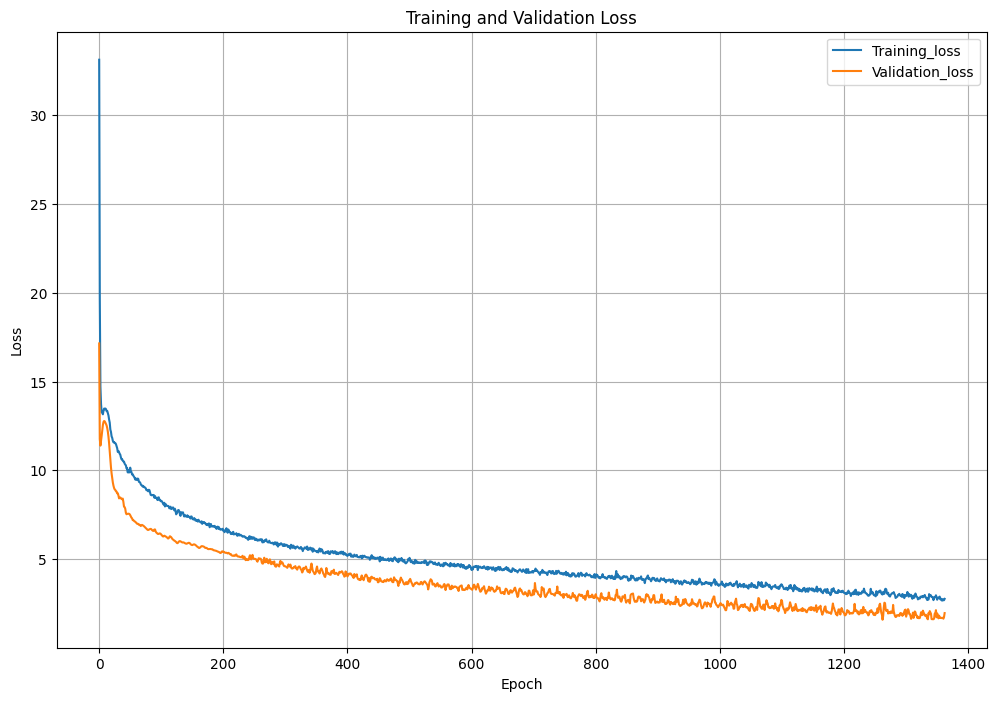

,loss,val_loss
0,33.134533,17.150089
1,19.666126,11.758221
2,14.723431,11.393066
3,13.736247,11.653567
4,13.273003,11.945401
...,...,...
1358,2.660863,1.688733
1359,2.745805,1.695828
1360,2.679617,1.641899
1361,2.685784,1.733287


In [41]:
plot_loss(df2_history)#,logy=True)#, ylim=[0, 25])
df2_history


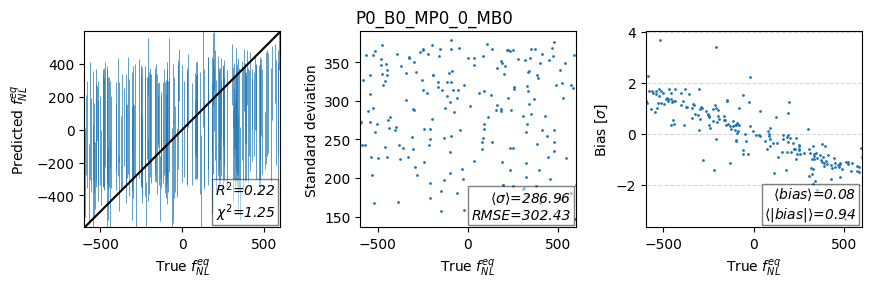

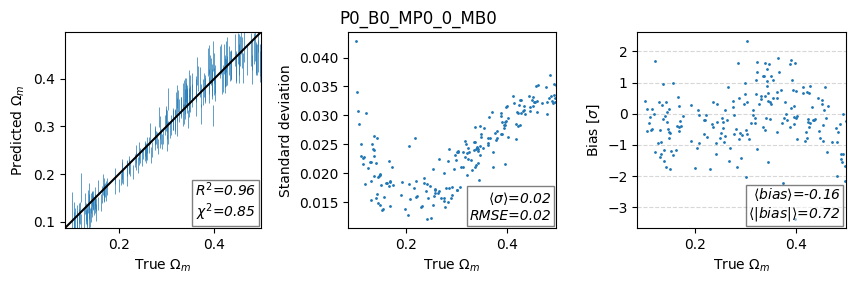

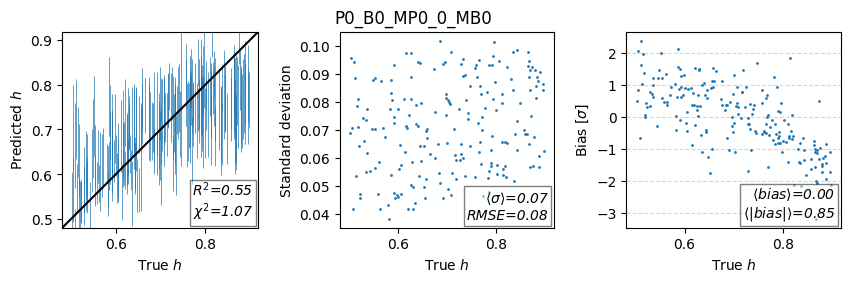

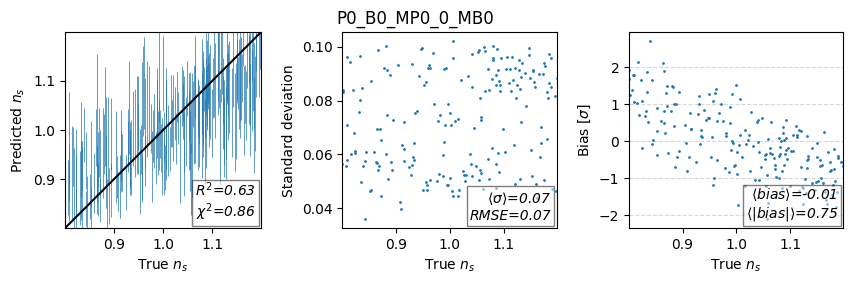

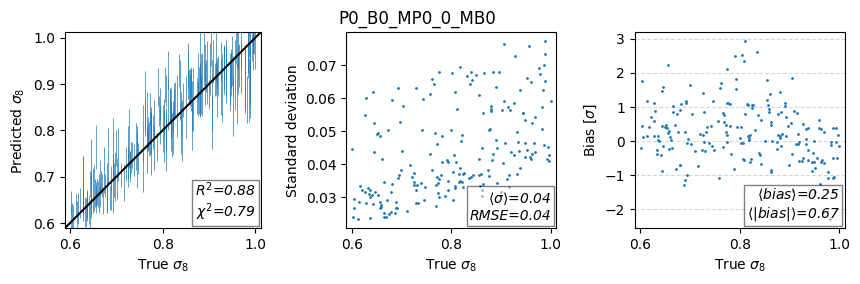

In [70]:
predictions2 = prediction(best_model2,X2_test,y2_test,mean_params,std_params,title = "P0_B0_MP0_0_MB0")

# 3. P0,B0,HMF

In [43]:
columns = columns3 #P0,B0,HMF
df_3 = input_data(columns,norm_lbl)
X3_train, X3_val, X3_test, y3_train, y3_val, y3_test = train_val_test_split(df_3 ,random_state = 1)

In [44]:
X_training_set = X3_train
y_training_set = y3_train

tuner3 = kt.BayesianOptimization(
    hp_model_for_dataset(),
    objective= 'val_loss',
    max_trials = 100,
    directory='/mnt/keras_tuner_dir-new/',
    project_name ='P0_B0_HMF__l2reg-patience100__0_100trials', #trained with kernel regularizer for pseudo_sigma
    )
# Running the HyperParameter Search
tuner3.search(X3_train, y3_train, validation_data=(X3_val, y3_val), epochs=1000000, callbacks= callback_early_stopping())#100000


Trial 100 Complete [00h 00m 22s]
val_loss: 70.19420623779297

Best val_loss So Far: 0.520143449306488
Total elapsed time: 01h 05m 46s


In [45]:

best_hp3 = tuner3.get_best_hyperparameters(num_trials=1)[0]
best_num_layers = best_hp3.get('num_layers')
best_architecture = [best_hp3.get(f"unit_num_{i}") for i in range(best_num_layers)]
best_learning_rate = best_hp3.get('learning_rate')
best_dropout_rate = best_hp3.get('dropout_rate')
best_base_learning_rate = best_hp3.get('learning_rate')
best_batch_size = best_hp3.get('batch_size')
best_regularization_rate =best_hp3.get('l2_regularization')
print(f"""
Best Hyperparameters:
- Number of Layers: {best_num_layers}
- Architecture: {best_architecture}
- Opt_Learning Rate: {best_learning_rate}
- Base Learning Rate (CLR): {best_base_learning_rate}
- Dropout Rate: {best_dropout_rate}
- Batch Size: {best_batch_size}
- Regularization Rate:{best_regularization_rate}
""")



Best Hyperparameters:
- Number of Layers: 5
- Architecture: [320, 416, 448, 256, 384]
- Opt_Learning Rate: 0.005889984761102996
- Base Learning Rate (CLR): 0.005889984761102996
- Dropout Rate: 0.19043094727780294
- Batch Size: 128
- Regularization Rate:0.002956650750385236



In [46]:
# TUNER SUMMARY
print(tuner3.results_summary())
best_model3 = tuner3.get_best_models()[0]
best_model3.summary()



Results summary
Results in /mnt/keras_tuner_dir-new/P0_B0_HMF__l2reg-patience100__0_100trials
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 021 summary
Hyperparameters:
num_layers: 5
unit_num_0: 320
dropout_rate: 0.19043094727780294
learning_rate: 0.005889984761102996
l2_regularization: 0.002956650750385236
unit_num_1: 416
unit_num_2: 448
unit_num_3: 256
unit_num_4: 384
unit_num_5: 576
base_learning_rate: 2.6464192364496168e-05
batch_size: 128
unit_num_6: 544
unit_num_7: 736
Score: 0.520143449306488

Trial 010 summary
Hyperparameters:
num_layers: 5
unit_num_0: 416
dropout_rate: 0.26896120360178105
learning_rate: 7.49119408980106e-05
l2_regularization: 0.00014801298593419265
unit_num_1: 800
unit_num_2: 544
unit_num_3: 192
unit_num_4: 256
unit_num_5: 288
base_learning_rate: 6.748145214398199e-05
batch_size: 256
unit_num_6: 160
unit_num_7: 640
Score: 0.5725001096725464

Trial 034 summary
Hyperparameters:
num_layers: 8
unit_num_0: 480
dropout_rate: 0.11355336167

In [47]:
# Fitting the model
hypermodel3 = hp_model_for_dataset()
best_model3 = hypermodel3.build(best_hp3)
histories3= hypermodel3.fit(best_hp3,best_model3,
    X3_train,
    y3_train,
    validation_data=(X3_val,
                     y3_val),
    epochs=1000000,
    callbacks= callback_early_stopping(),
    verbose=1,
)
# Histories return 
df3_history = pd.DataFrame(histories3.history)


Epoch 1/1000000
5/5 [==============================] - 3s 170ms/step - loss: 35.2014 - val_loss: 19.4735
Epoch 2/1000000
5/5 [==============================] - 1s 185ms/step - loss: 20.3615 - val_loss: 11.0675
Epoch 3/1000000
5/5 [==============================] - 0s 12ms/step - loss: 16.2583 - val_loss: 9.7216
Epoch 4/1000000
5/5 [==============================] - 0s 11ms/step - loss: 14.2589 - val_loss: 9.3677
Epoch 5/1000000
5/5 [==============================] - 0s 10ms/step - loss: 13.5607 - val_loss: 9.4028
Epoch 6/1000000
5/5 [==============================] - 0s 10ms/step - loss: 13.6790 - val_loss: 9.3952
Epoch 7/1000000
5/5 [==============================] - 0s 10ms/step - loss: 13.1267 - val_loss: 9.4041
Epoch 8/1000000
5/5 [==============================] - 0s 11ms/step - loss: 13.0446 - val_loss: 9.3660
Epoch 9/1000000
5/5 [==============================] - 0s 11ms/step - loss: 12.9483 - val_loss: 9.3624
Epoch 10/1000000
5/5 [==============================] - 0s 11ms/step 

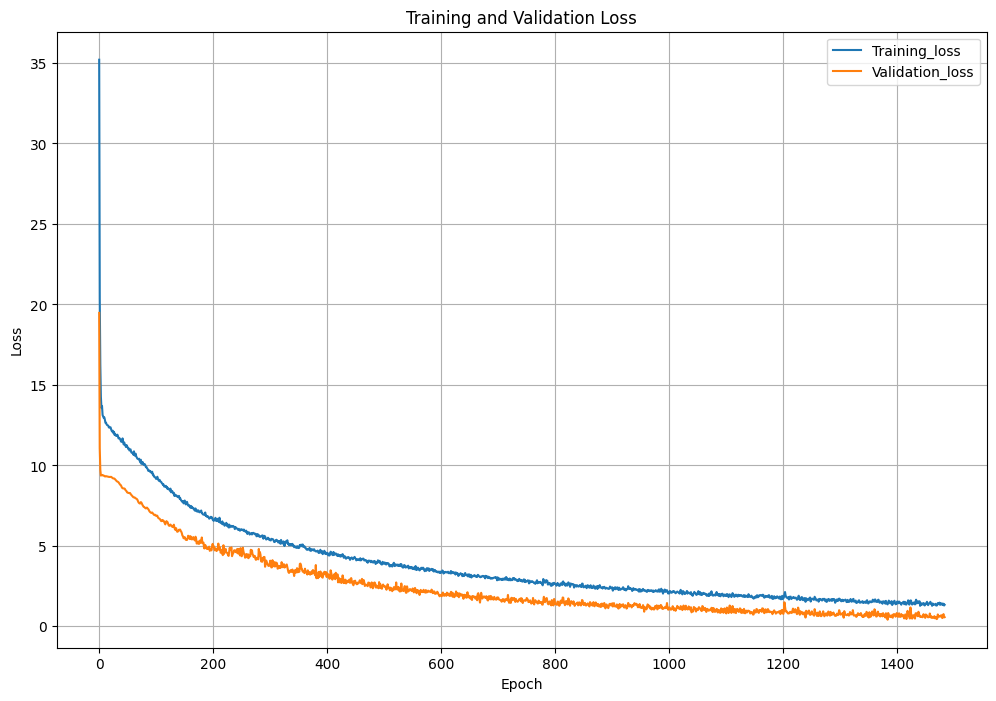

,loss,val_loss
0,35.201439,19.473476
1,20.361519,11.067475
2,16.258284,9.721576
3,14.258900,9.367739
4,13.560653,9.402809
...,...,...
1479,1.416332,0.517142
1480,1.328648,0.664850
1481,1.405590,0.761696
1482,1.295125,0.555087


In [48]:
plot_loss(df3_history)#,logy=True)#, ylim=[0, 25])
df3_history

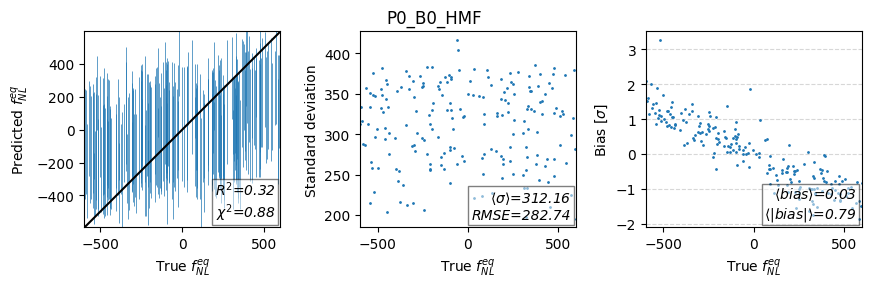

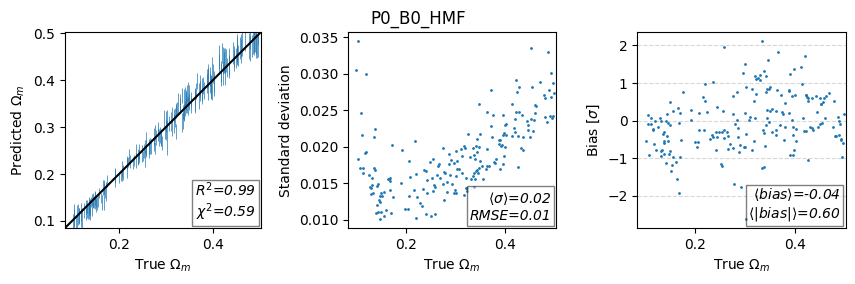

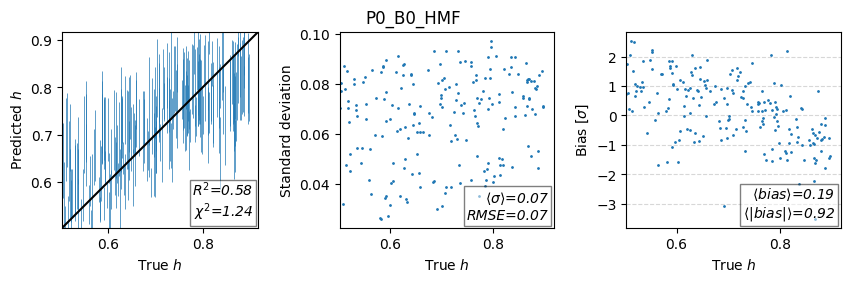

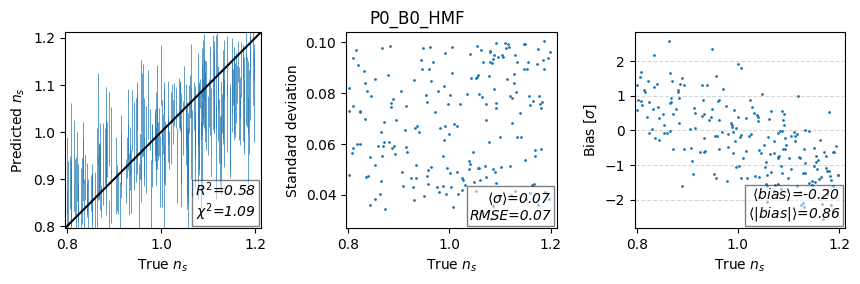

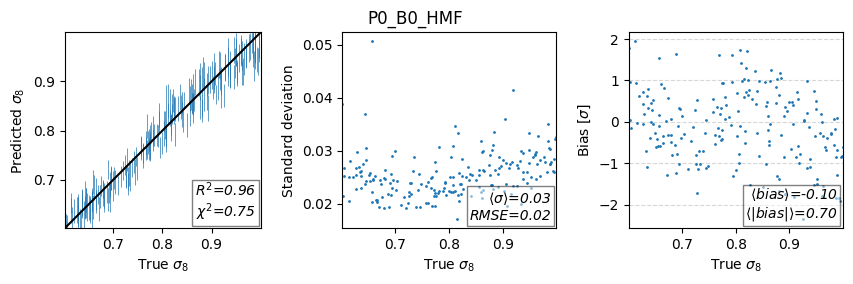

In [71]:
predictions3 = prediction(best_model3,X3_test,y3_test,mean_params,std_params,title = "P0_B0_HMF")

# 4. P0,MP0_0,HMF

In [95]:
columns = columns4 #[P0,MP0_0,HMF]
df_4 = input_data(columns,norm_lbl)
X4_train, X4_val, X4_test, y4_train, y4_val, y4_test = train_val_test_split(df_4 ,random_state = 1)

In [96]:

X_training_set = X4_train
y_training_set = y4_train

tuner4 = kt.BayesianOptimization(
    hp_model_for_dataset(),
    objective= 'val_loss',
    max_trials = 100,
    directory='/mnt/keras_tuner_dir-new/',
    project_name ='P0_MP0_0_HMF__l2reg-patience100__0_100trials', #trained with kernel regularizer for pseudo_sigma
    )
# Running the HyperParameter Search
tuner4.search(X4_train, y4_train, validation_data=(X4_val, y4_val), epochs=1000000, callbacks= callback_early_stopping())#100000


Reloading Tuner from /mnt/keras_tuner_dir-new/P0_MP0_0_HMF__l2reg-patience100__0_100trials/tuner0.json


In [97]:

best_hp4 = tuner4.get_best_hyperparameters(num_trials=1)[0]
best_num_layers = best_hp4.get('num_layers')
best_architecture = [best_hp4.get(f"unit_num_{i}") for i in range(best_num_layers)]
best_learning_rate = best_hp4.get('learning_rate')
best_dropout_rate = best_hp4.get('dropout_rate')
best_base_learning_rate = best_hp4.get('learning_rate')
best_batch_size = best_hp4.get('batch_size')
best_regularization_rate =best_hp4.get('l2_regularization')
print(f"""
Best Hyperparameters:
- Number of Layers: {best_num_layers}
- Architecture: {best_architecture}
- Opt_Learning Rate: {best_learning_rate}
- Base Learning Rate (CLR): {best_base_learning_rate}
- Dropout Rate: {best_dropout_rate}
- Batch Size: {best_batch_size}
- Regularization Rate:{best_regularization_rate}
""")



Best Hyperparameters:
- Number of Layers: 5
- Architecture: [384, 672, 448, 352, 768]
- Opt_Learning Rate: 0.0002927867122633045
- Base Learning Rate (CLR): 0.0002927867122633045
- Dropout Rate: 0.10930795526278021
- Batch Size: 32
- Regularization Rate:8.937008983237725e-05



In [98]:

# TUNER SUMMARY
print(tuner4.results_summary())
best_model4 = tuner4.get_best_models()[0]
best_model4.summary()


Results summary
Results in /mnt/keras_tuner_dir-new/P0_MP0_0_HMF__l2reg-patience100__0_100trials
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 011 summary
Hyperparameters:
num_layers: 5
unit_num_0: 384
dropout_rate: 0.10930795526278021
learning_rate: 0.0002927867122633045
l2_regularization: 8.937008983237725e-05
unit_num_1: 672
base_learning_rate: 1.314283117273924e-05
batch_size: 32
unit_num_2: 448
unit_num_3: 352
unit_num_4: 768
unit_num_5: 640
unit_num_6: 832
unit_num_7: 992
Score: -0.015395913273096085

Trial 089 summary
Hyperparameters:
num_layers: 8
unit_num_0: 608
dropout_rate: 0.1
learning_rate: 0.00021569708001997493
l2_regularization: 0.00039617017088079334
unit_num_1: 32
base_learning_rate: 3.038948214465122e-05
batch_size: 16
unit_num_2: 384
unit_num_3: 1024
unit_num_4: 1024
unit_num_5: 832
unit_num_6: 832
unit_num_7: 32
Score: 0.4051203429698944

Trial 083 summary
Hyperparameters:
num_layers: 8
unit_num_0: 736
dropout_rate: 0.1
learning_rate: 0.

In [ ]:

# Fitting the model
hypermodel4 = hp_model_for_dataset()
best_model4 = hypermodel4.build(best_hp4)
histories4= hypermodel4.fit(best_hp4,best_model4,
    X4_train,
    y4_train,
    validation_data=(X4_val,
                     y4_val),
    epochs=1000000,
    callbacks= callback_early_stopping(),
    verbose=1,
)
# Histories return 
df4_history = pd.DataFrame(histories4.history)



Epoch 1/1000000
19/19 [==============================] - 3s 42ms/step - loss: 17.0442 - val_loss: 9.7943
Epoch 2/1000000
19/19 [==============================] - 1s 44ms/step - loss: 11.9530 - val_loss: 9.0710
Epoch 3/1000000
19/19 [==============================] - 0s 6ms/step - loss: 11.6684 - val_loss: 8.7828
Epoch 4/1000000
19/19 [==============================] - 0s 6ms/step - loss: 11.3797 - val_loss: 8.6763
Epoch 5/1000000
19/19 [==============================] - 0s 6ms/step - loss: 11.3087 - val_loss: 8.5233
Epoch 6/1000000
19/19 [==============================] - 0s 6ms/step - loss: 11.2162 - val_loss: 8.3745
Epoch 7/1000000
19/19 [==============================] - 0s 6ms/step - loss: 11.1276 - val_loss: 8.3716
Epoch 8/1000000
19/19 [==============================] - 0s 6ms/step - loss: 11.1210 - val_loss: 8.2922
Epoch 9/1000000
19/19 [==============================] - 0s 6ms/step - loss: 10.8433 - val_loss: 8.1927
Epoch 10/1000000
19/19 [==============================] - 0s 7

In [ ]:
plot_loss(df4_history)#,logy=True)#, ylim=[0, 25])
df4_history


In [ ]:
predictions4 = prediction(best_model4,X4_test,y4_test,mean_params,std_params,title = "P0_MP0_0_HMF")

# 5. P0,B0,MP0_0,MB0,HMF

In [59]:
columns = columns5 #P0,B0,MP0_0,MB0,HMF
df_5 = input_data(columns,norm_lbl)
X5_train, X5_val, X5_test, y5_train, y5_val, y5_test = train_val_test_split(df_5 ,random_state = 1)


In [60]:
X_training_set = X5_train
y_training_set = y5_train

tuner5 = kt.BayesianOptimization(
    hp_model_for_dataset(),
    objective= 'val_loss',
    max_trials = 100,
    directory='/mnt/keras_tuner_dir-new/',
    project_name ='P0_B0_MP0_0_MB0_HMF__l2reg-patience100__0_100trials', #trained with kernel regularizer for pseudo_sigma
    )
# Running the HyperParameter Search
tuner5.search(X5_train, y5_train, validation_data=(X5_val, y5_val), epochs=1000000, callbacks= callback_early_stopping())#100000


Trial 100 Complete [00h 00m 16s]
val_loss: 21.544477462768555

Best val_loss So Far: 0.36244314908981323
Total elapsed time: 00h 51m 11s


In [61]:

best_hp5 = tuner5.get_best_hyperparameters(num_trials=1)[0]
best_num_layers = best_hp5.get('num_layers')
best_architecture = [best_hp5.get(f"unit_num_{i}") for i in range(best_num_layers)]
best_learning_rate = best_hp5.get('learning_rate')
best_dropout_rate = best_hp5.get('dropout_rate')
best_base_learning_rate = best_hp5.get('learning_rate')
best_batch_size = best_hp5.get('batch_size')
best_regularization_rate =best_hp5.get('l2_regularization')
print(f"""
Best Hyperparameters:
- Number of Layers: {best_num_layers}
- Architecture: {best_architecture}
- Opt_Learning Rate: {best_learning_rate}
- Base Learning Rate (CLR): {best_base_learning_rate}
- Dropout Rate: {best_dropout_rate}
- Batch Size: {best_batch_size}
- Regularization Rate:{best_regularization_rate}
""")




Best Hyperparameters:
- Number of Layers: 6
- Architecture: [128, 320, 128, 320, 288, 608]
- Opt_Learning Rate: 0.0030143075201347373
- Base Learning Rate (CLR): 0.0030143075201347373
- Dropout Rate: 0.12531063729020325
- Batch Size: 256
- Regularization Rate:0.0027721423000732436



In [62]:
# TUNER SUMMARY
print(tuner5.results_summary())
best_model5 = tuner5.get_best_models()[0]
best_model5.summary()


Results summary
Results in /mnt/keras_tuner_dir-new/P0_B0_MP0_0_MB0_HMF__l2reg-patience100__0_100trials
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 031 summary
Hyperparameters:
num_layers: 6
unit_num_0: 128
dropout_rate: 0.12531063729020325
learning_rate: 0.0030143075201347373
l2_regularization: 0.0027721423000732436
unit_num_1: 320
unit_num_2: 128
unit_num_3: 320
unit_num_4: 288
unit_num_5: 608
base_learning_rate: 2.017827572072543e-05
batch_size: 256
unit_num_6: 384
unit_num_7: 960
Score: 0.36244314908981323

Trial 065 summary
Hyperparameters:
num_layers: 5
unit_num_0: 448
dropout_rate: 0.24958096014629413
learning_rate: 1e-05
l2_regularization: 0.0008573456710831525
unit_num_1: 192
unit_num_2: 704
unit_num_3: 256
unit_num_4: 384
unit_num_5: 1024
base_learning_rate: 8.150479748324529e-05
batch_size: 256
unit_num_6: 448
unit_num_7: 448
Score: 0.3944735825061798

Trial 009 summary
Hyperparameters:
num_layers: 4
unit_num_0: 288
dropout_rate: 0.4950369340039

In [63]:
# Fitting the model
hypermodel5 = hp_model_for_dataset()
best_model5 = hypermodel5.build(best_hp5)
histories5 = hypermodel5.fit(best_hp5,best_model5,
    X5_train,
    y5_train,
    validation_data=(X5_val,
                     y5_val),
    epochs=1000000,
    callbacks= callback_early_stopping(),
    verbose=1,
)
# Histories return 
df5_history = pd.DataFrame(histories5.history)


Epoch 1/1000000
3/3 [==============================] - 4s 337ms/step - loss: 28.6949 - val_loss: 26.9633
Epoch 2/1000000
3/3 [==============================] - 1s 288ms/step - loss: 21.9667 - val_loss: 15.4394
Epoch 3/1000000
3/3 [==============================] - 0s 19ms/step - loss: 17.7027 - val_loss: 11.1406
Epoch 4/1000000
3/3 [==============================] - 0s 19ms/step - loss: 15.1055 - val_loss: 10.1504
Epoch 5/1000000
3/3 [==============================] - 0s 15ms/step - loss: 13.8865 - val_loss: 10.1539
Epoch 6/1000000
3/3 [==============================] - 0s 15ms/step - loss: 13.3370 - val_loss: 10.3173
Epoch 7/1000000
3/3 [==============================] - 0s 16ms/step - loss: 13.1355 - val_loss: 10.4104
Epoch 8/1000000
3/3 [==============================] - 0s 16ms/step - loss: 12.8257 - val_loss: 10.4391
Epoch 9/1000000
3/3 [==============================] - 0s 15ms/step - loss: 12.9422 - val_loss: 10.4251
Epoch 10/1000000
3/3 [==============================] - 0s 16m

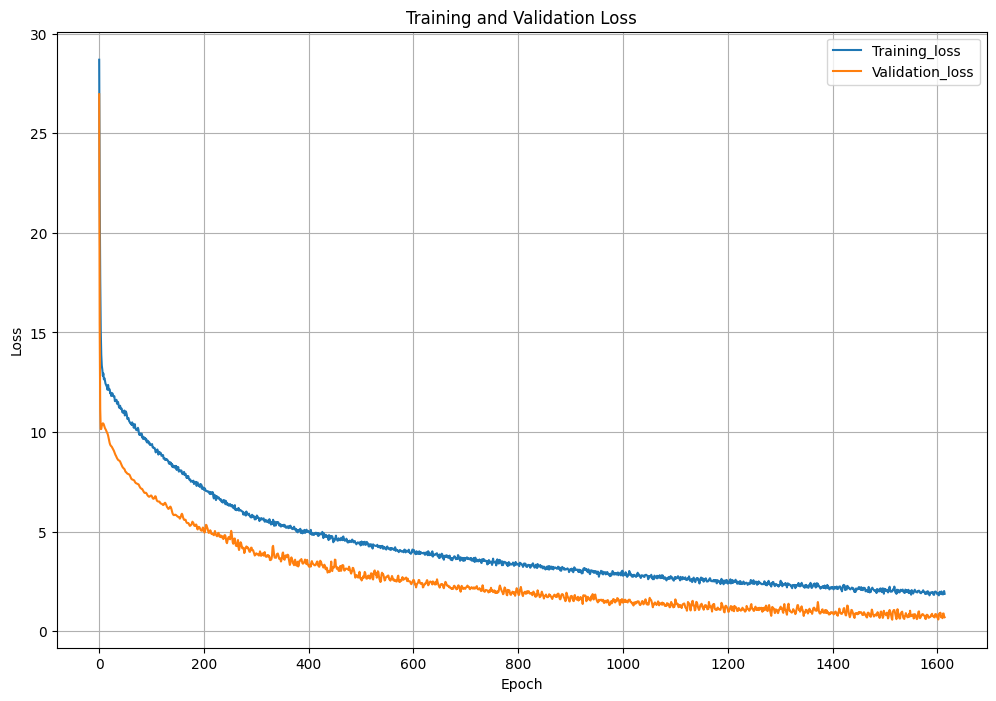

,loss,val_loss
0,28.694921,26.963345
1,21.966661,15.439396
2,17.702740,11.140555
3,15.105515,10.150352
4,13.886530,10.153931
...,...,...
1610,1.907872,0.654338
1611,1.847309,0.889355
1612,1.920571,0.890331
1613,2.019182,0.754169


In [64]:
plot_loss(df5_history)#,logy=True)#, ylim=[0, 25])
df5_history

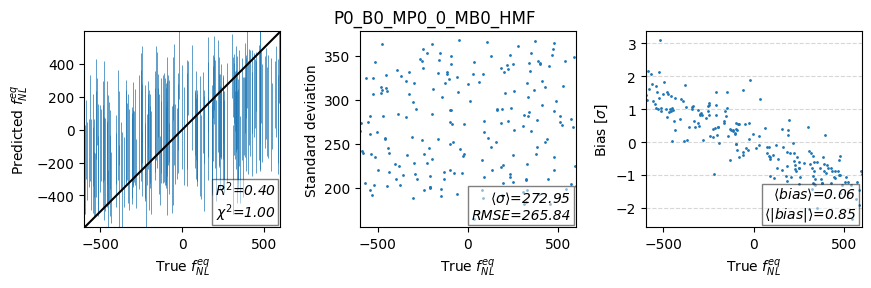

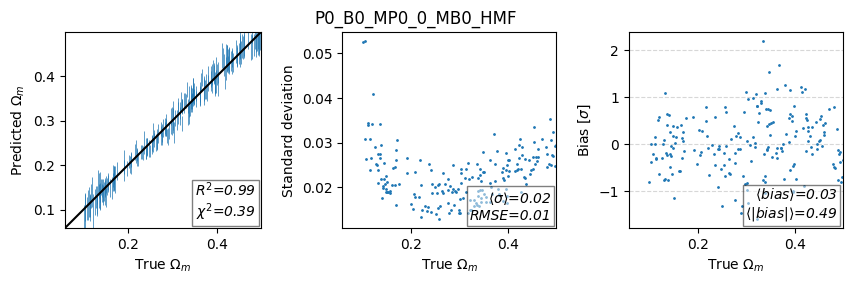

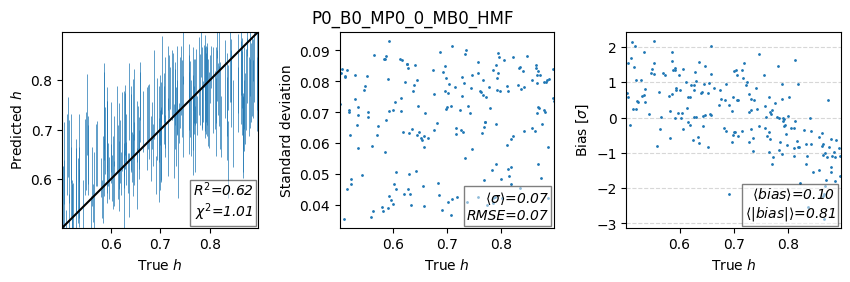

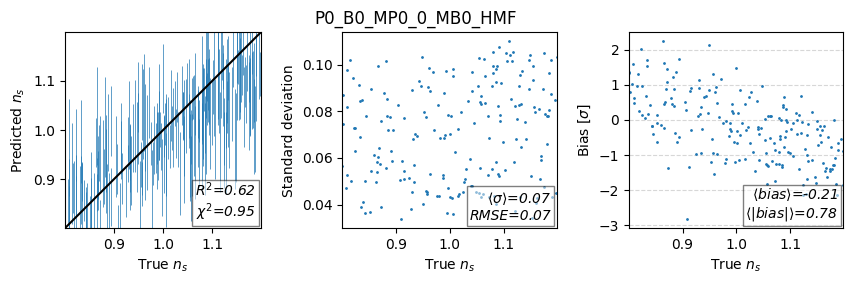

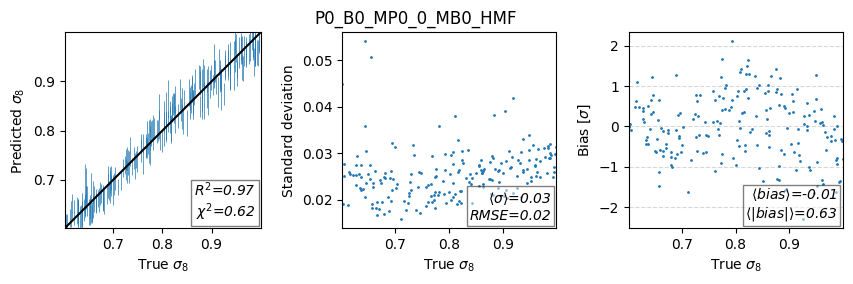

In [73]:
predictions5 = prediction(best_model5,X5_test,y5_test,mean_params,std_params,title = "P0_B0_MP0_0_MB0_HMF")

(array([[-8.9400e+01,  3.5340e-01,  8.8060e-01,  8.8380e-01,  7.2420e-01],
        [ 2.3340e+02,  3.2180e-01,  6.4740e-01,  8.2420e-01,  8.2140e-01],
        [-4.7700e+02,  3.7220e-01,  6.7620e-01,  1.0210e+00,  6.5300e-01],
        [-3.4140e+02,  3.1340e-01,  7.4180e-01,  1.1814e+00,  7.9980e-01],
        [-4.2600e+01,  2.1660e-01,  8.6780e-01,  8.3460e-01,  7.1060e-01],
        [-2.4300e+02,  2.2020e-01,  7.4660e-01,  1.1666e+00,  9.3340e-01],
        [ 1.9380e+02,  1.2900e-01,  7.5700e-01,  1.0038e+00,  8.0700e-01],
        [-3.5700e+02,  1.9940e-01,  6.5540e-01,  1.1626e+00,  7.7340e-01],
        [ 3.4980e+02,  1.6660e-01,  6.0620e-01,  9.5700e-01,  6.8940e-01],
        [-2.2200e+01,  1.3780e-01,  6.2700e-01,  9.2460e-01,  8.1060e-01],
        [ 1.3020e+02,  4.9220e-01,  5.8620e-01,  1.1734e+00,  6.2700e-01],
        [ 2.0340e+02,  3.4980e-01,  6.3620e-01,  1.1650e+00,  6.8020e-01],
        [ 2.2260e+02,  2.9220e-01,  8.6260e-01,  8.7060e-01,  6.8900e-01],
        [-2.0820e+02,  1.